In [89]:
import pandas as pd
import numpy as np
import io
import xgboost as xgb

In [99]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(r"C:\Users\user\Desktop\repos\igem-model\data\attempt.csv")
X = df.drop(columns=["infection"])
X["density"] = X["population"]/X["area"]
y = df["infection"].astype("float64")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


In [91]:
y.describe()

count    10094.000000
mean         5.802061
std         16.469844
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        216.000000
Name: infection, dtype: float64

In [92]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

estimators = [
    #('encoder', TargetEncoder()),
    ('clf', XGBRegressor(random_state=8))
]
pipe = Pipeline(steps=estimators)
pipe

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None


In [93]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}
score = "neg_mean_squared_error"
#score = "r2"
opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring=score, random_state=8) 

In [94]:
opt.fit(X_train, y_train)
model = opt.best_estimator_.named_steps['clf']

In [95]:
print(opt.score(X_train,y_train), opt.score(X_test, y_test))    

-11.65106802165025 -26.965655484880557


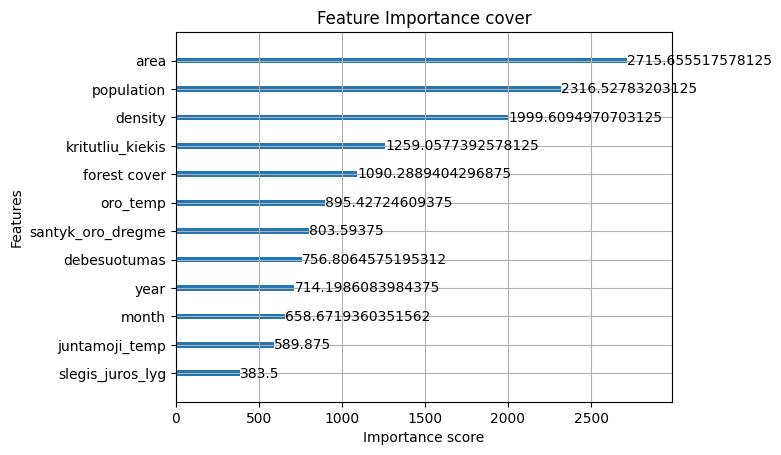

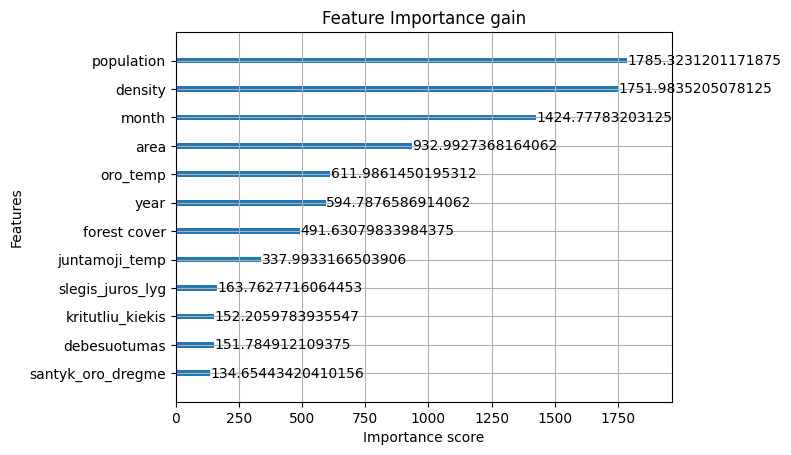

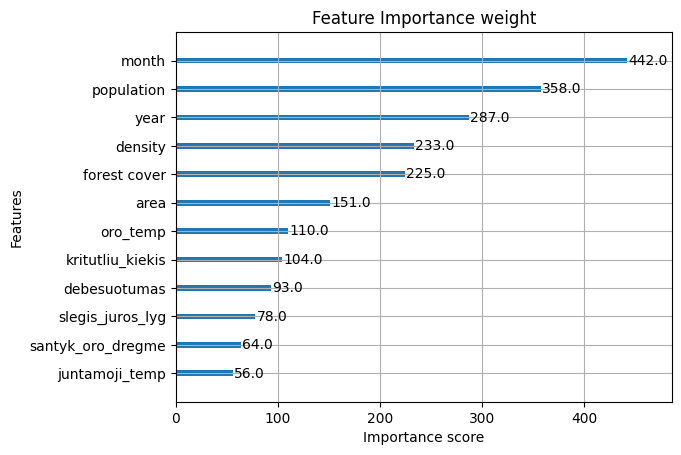

In [96]:
import matplotlib.pyplot as plt
for way in ["cover", "gain", "weight"]: 
    xgb.plot_importance(model, importance_type=way, height=0.2)
    plt.title(f'Feature Importance {way}')
    plt.show()

In [97]:
opt.predict(X_test)

array([ 1.4956081 , -0.15707064, 10.048187  , ...,  2.0231783 ,
        3.1194398 ,  3.5558932 ], dtype=float32)

In [98]:
def smape(y_true, y_pred):
    """Symmetric MAPE - handles zeros better"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def safe_mape(y_true, y_pred, epsilon=1e-8):
    """MAPE that handles zero values"""
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Or exclude zeros entirely
def mape_no_zeros(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def relu(x):
    if x > 0: return x
    else: return 0

def MSE(y_true,y_pred):
    return np.mean(np.power(y_true-y_pred,2))
